# Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import spearmanr, pearsonr

import missingno as mno

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

In [12]:
import pandas
print(pandas.__version__)

2.2.2


# Loading Data

In [ ]:
# Specify your path to Capstone folder.

main_path = "/content/drive/MyDrive/Capstone_Diana/Capstone/"

In [ ]:
if "drive" in main_path:
    from google.colab import drive
    drive.mount("/content/drive")

In [ ]:
# Specify your original database.
# mechano - for MechanoProDB
# protherm - for ProThermDB

database = "protherm"

In [ ]:
# Loading the original dataset.

sequence_method = "protbert"
text_method = "scibert"

if database == "mechano":
    db_name = "MechanoPro-DB.xlsx"
    db_path = os.path.join(f"{main_path}Data/", db_name)
    db_load = pd.read_excel(db_path)

    numeric_method = "regression_imputings"
    dataset_length = 127

elif database == "protherm":
    db_name = "ProThermDB.tsv"
    db_path = os.path.join(f"{main_path}Data/", db_name)
    db_load = pd.read_csv(db_path, sep="\t", index_col=0)
    db_load.replace("-", np.nan, inplace=True)

    numeric_method = "none"
    dataset_length = 14645

else:
    print("File not found")

dataset_name = f"tokenized_dataset_{numeric_method}_{sequence_method}_{text_method}_{dataset_length}_{database}"
pickle_path = f"{main_path}Tokenized_results/{dataset_name}.pkl"
db_load.head(4)

PROTEIN UniProt_ID   MUTATION  \
NO                                                                            
1   Histidine phosphocarrier protein (HPr) kinase/...     O34483  wild-type   
2   Histidine phosphocarrier protein (HPr) kinase/...     O34483  wild-type   
3   Histidine phosphocarrier protein (HPr) kinase/...     O34483  wild-type   
4   Histidine phosphocarrier protein (HPr) kinase/...     O34483  wild-type   

               SOURCE PDB_wild PDB_Chain_Mutation SEC_STR  ASA   pH T_(C)  \
NO                                                                          
1   Bacillus subtilis      NaN                NaN     NaN  NaN  7.0    25   
2   Bacillus subtilis      NaN                NaN     NaN  NaN  7.0    25   
3   Bacillus subtilis      NaN                NaN     NaN  NaN  7.0    25   
4   Bacillus subtilis      NaN                NaN     NaN  NaN  7.0    25   

   Tm_(C) ∆Tm_(C) ∆∆G_(kcal/mol) ∆∆G_H2O_(kcal/mol) STATE REVERSIBILITY  \
NO                                                                        
1     NaN     NaN            NaN                NaN   NaN            No   
2     NaN     NaN            NaN                NaN   NaN            No   
3     NaN     NaN            NaN                NaN   NaN            No   
4     NaN     NaN            NaN                NaN   NaN            No   

   PubMed_ID                                          KEY_WORDS  \
NO                                                                
1   33810099  circular dichroism; conformational stability; ...   
2   33810099  circular dichroism; conformational stability; ...   
3   33810099  circular dichroism; conformational stability; ...   
4   33810099  circular dichroism; conformational stability; ...   

                                          REFERENCE  \
NO                                                    
1   Int J Mol Sci. 22(6):3231 (2021) PMID: 33810099   
2   Int J Mol Sci. 22(6):3231 (2021) PMID: 33810099   
3   Int J Mol Sci. 22(6):3231 (2021) PMID: 33810099   
4   Int J Mol Sci. 22(6):3231 (2021) PMID: 33810099   

                                               AUTHOR  
NO                                                     
1   Neira JL, Cámara-Artigas A, Hernández-Cifre JG...  
2   Neira JL, Cámara-Artigas A, Hernández-Cifre JG...  
3   Neira JL, Cámara-Artigas A, Hernández-Cifre JG...  
4   Neira JL, Cámara-Artigas A, Hernández-Cifre JG...

In [ ]:
mechano = False
if db_name == "MechanoPro-DB.xlsx":
    mechano = True

In [ ]:
db_load.isna().sum()

PROTEIN                   0
UniProt_ID             2575
MUTATION                855
SOURCE                    1
PDB_wild               4324
PDB_Chain_Mutation    13912
SEC_STR               15271
ASA                   17585
pH                       84
T_(C)                 16500
Tm_(C)                16233
∆Tm_(C)               25528
∆∆G_(kcal/mol)        29083
∆∆G_H2O_(kcal/mol)    26190
STATE                 25997
REVERSIBILITY          1638
PubMed_ID               519
KEY_WORDS                 0
REFERENCE                 0
AUTHOR                    0
dtype: int64

# Preprocessing of Data

In [ ]:
# Removing unnecessary columns from datasets and specifying lists of columns for future visualizations.

if mechano:
    db_load = db_load[~db_load["Technique"].isin(["all atom SMD simulation","Monte Carlo Simulations","all atom SMD simulations",
                                    "Coarse-grained MD simulations"])]
    db_load.columns = db_load.columns.str.strip()
    db_load.rename(columns={"Name (Click for details)": "Name"}, inplace=True)
    drop_cols = ["Released", "Authors", "Pulling Reference", "DOI Structure", "3D Structure (click on the protein)",
              "Mechanical Clamp"] # for temperature we assume all are under 20 degrees (room temp), only 3 were 23
    db_load.drop(columns=drop_cols, axis=1,inplace=True)
    db_load["Mutations"] = db_load["Mutations"].str.title()
    new_categorical_cols = ["Name", "PDB ID", "SCOP annotation", "Experimental Conditions",
                          "Organism", "Classification", "Technique", "Pulling Mode", "Unfolding Pathway", "Pulling Coordinates",
                          "Sequence"]
    temp_num_cols = ["Standard Deviation of force [pN]",
                  "Velocity [nm/s]","Xu [nm]","ΔG [kBT]","Contour Length [nm]"]
    final_temp_cols = [*new_categorical_cols, *temp_num_cols]
    db_load_temp = db_load[final_temp_cols]

else:
    db_load.columns = db_load.columns.str.strip()
    db_load.rename(columns={"SOURCE": "ORGANISM"}, inplace=True)
    drop_cols = ["PubMed_ID",	"KEY_WORDS", "REFERENCE", "AUTHOR", "PDB_Chain_Mutation", "STATE"]
    convert_cols = ["∆∆G_(kcal/mol)", "Tm_(C)", "T_(C)", "∆Tm_(C)", "∆∆G_H2O_(kcal/mol)"]
    db_load.drop(columns=drop_cols, axis=1,inplace=True)
    for col in convert_cols:
        db_load[col] = pd.to_numeric(db_load[col], errors="coerce")
    new_categorical_cols = ["PROTEIN", "UniProt_ID", "ORGANISM", "PDB_wild", "SEC_STR"]

In [ ]:
# This plot is visualized to see the amount of values we have.
# This visualization is done only for MechanoProDB, as for ProThermDB we have only 3 features to use, all originally filled.

if mechano:
    db_load_temp = db_load_temp.dropna(subset=["Sequence"])
    mno.matrix(db_load_temp, figsize = (20, 6))

# EDA analysis

In [ ]:
df = db_load.copy()

In [ ]:
# Checking missing values summary.

missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_summary = pd.DataFrame({
    "Column Name": df.columns,
    "Missing Values": missing_values.values,
    "Missing Percentage": missing_percentage.values
})
missing_summary

Column Name  Missing Values  Missing Percentage
0              PROTEIN               0            0.000000
1           UniProt_ID            2575            7.977076
2             MUTATION             855            2.648699
3             ORGANISM               1            0.003098
4             PDB_wild            4324           13.395291
5              SEC_STR           15271           47.307931
6                  ASA           17585           54.476456
7                   pH              84            0.260223
8                T_(C)           16500           51.115242
9               Tm_(C)           18250           56.536555
10             ∆Tm_(C)           25567           79.203841
11      ∆∆G_(kcal/mol)           29104           90.161090
12  ∆∆G_H2O_(kcal/mol)           26262           81.356877
13       REVERSIBILITY            1638            5.074349

In [ ]:
if mechano:
    df.drop("F05 [pN]", axis=1, inplace=True)
else:
    pass

## Distributions and Frequency of values

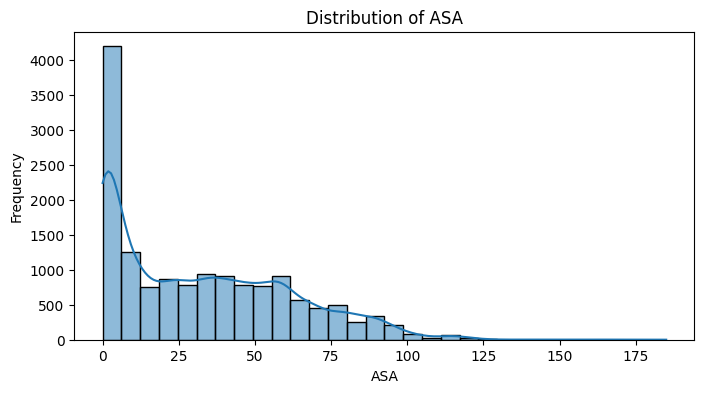

Ranges for ASA: (0.0, 185.0)


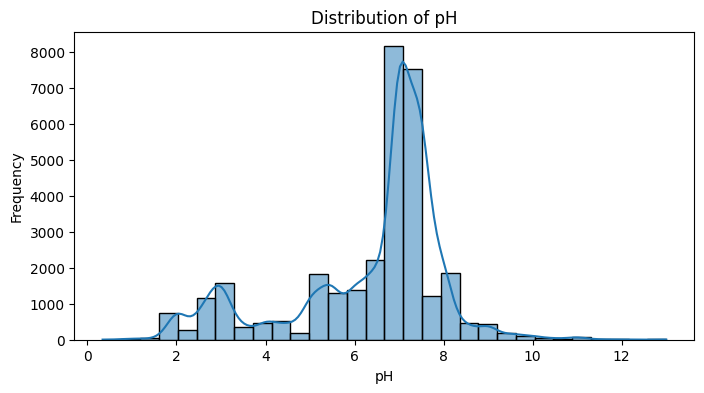

Ranges for pH: (0.34, 13.0)


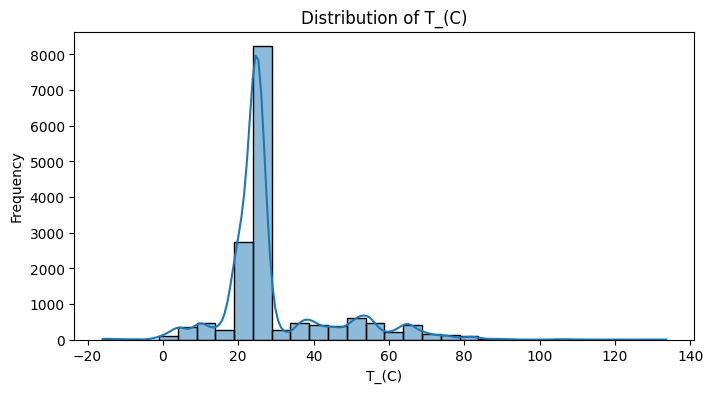

Ranges for T_(C): (-16.0, 133.6)


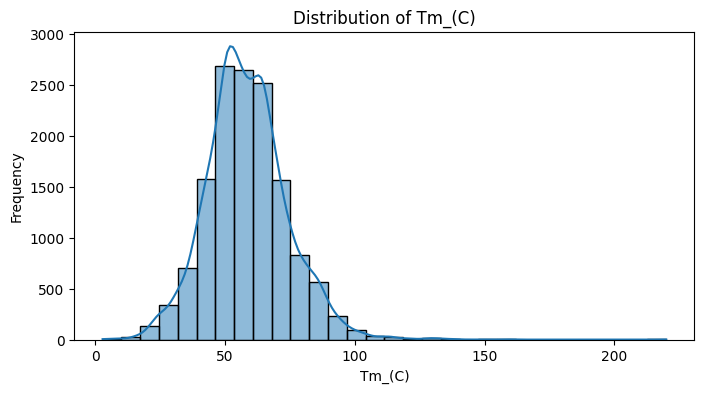

Ranges for Tm_(C): (2.8, 220.0)


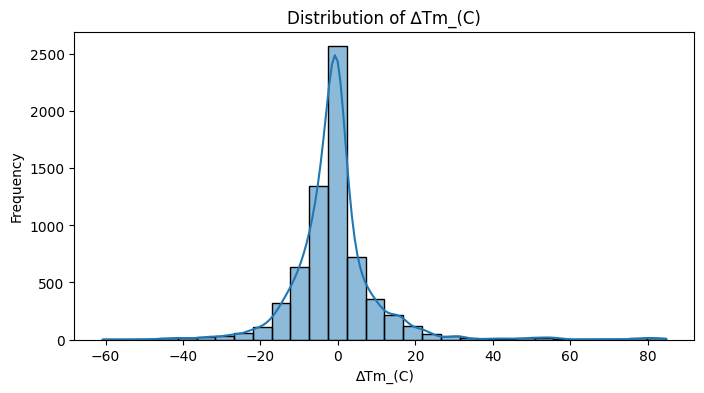

Ranges for ∆Tm_(C): (-60.79, 84.8)


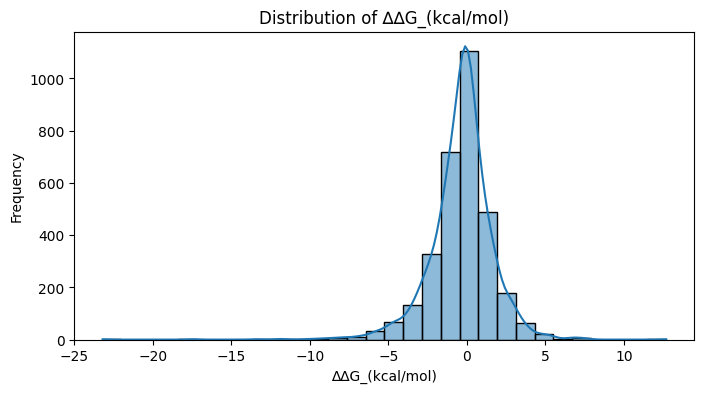

Ranges for ∆∆G_(kcal/mol): (-23.21, 12.7)


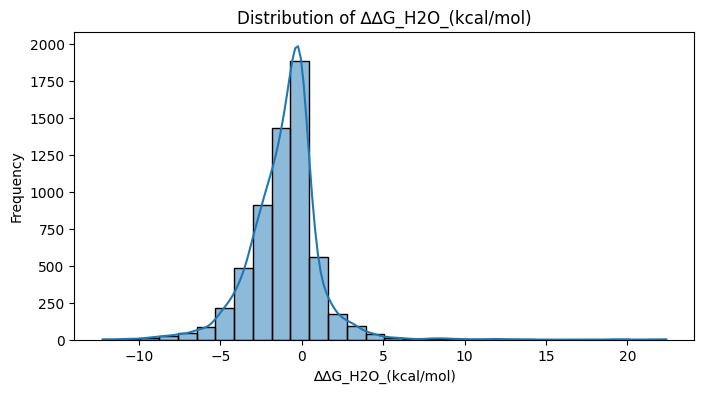

Ranges for ∆∆G_H2O_(kcal/mol): (-12.23, 22.39)


In [ ]:
# Selecting numeric columns by specifying data type.
# Visualizing the distribution of values.

numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()
    print(f"Ranges for {col}: ({min(df[col].dropna())}, {max(df[col].dropna())})")

In [ ]:
# Visualizing the unique values and their frequencies for categorical columns.

pre_categorical_cols = df.select_dtypes(include=["object"]).columns
if mechano:
    remove = ["Name", "Uniprot", "PDB ID", "Experimental Conditions", "Domain Coords", "Unfolding Annotation", \
              "Unfolding Pathway", "Sequence", "Pulling Coordinates"]
else:
    remove = ["PROTEIN", "UniProt_ID", "MUTATION", "ORGANISM", "PDB_wild", "SEC_STR", "REVERSIBILITY"]
categorical_cols = [x for x in pre_categorical_cols if x not in remove]


for col in categorical_cols:
    print(col)
    plt.figure(figsize=(8, 4))
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    if col in ["Organism", "Classification"]:
        plt.yticks(fontsize=4)
    else:
        plt.yticks(fontsize=10)
    plt.ylabel(" ")
    plt.show()

## Clusterization

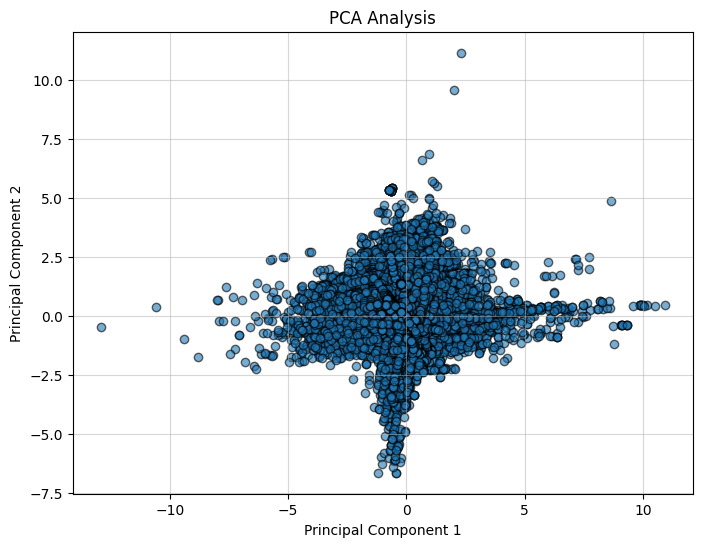

Explained Variance Ratio: [0.18619894 0.16644929]


In [ ]:
# Performing PCA analysis to see possible clusterization of data (to check for similarities).

if mechano:
    threshold = 80
else:
    threshold = 95
cols_to_drop = [elm for elm in missing_summary[missing_summary["Missing Percentage"] > threshold]["Column Name"].values if elm != "F05 [pN]"]
df_cleaned = df.drop(columns=cols_to_drop)

df_numeric_cleaned = df_cleaned.select_dtypes(include=["int64", "float64"])
imputer = SimpleImputer(strategy="mean")
df_numeric_cleaned = pd.DataFrame(imputer.fit_transform(df_numeric_cleaned), columns=df_numeric_cleaned.columns)

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric_cleaned)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, edgecolors="black")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Analysis")
plt.grid(alpha=0.5)
plt.show()

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

### K-MEANS

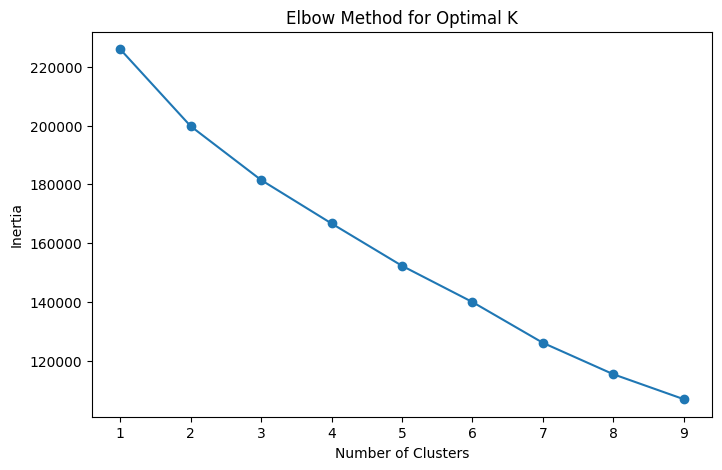

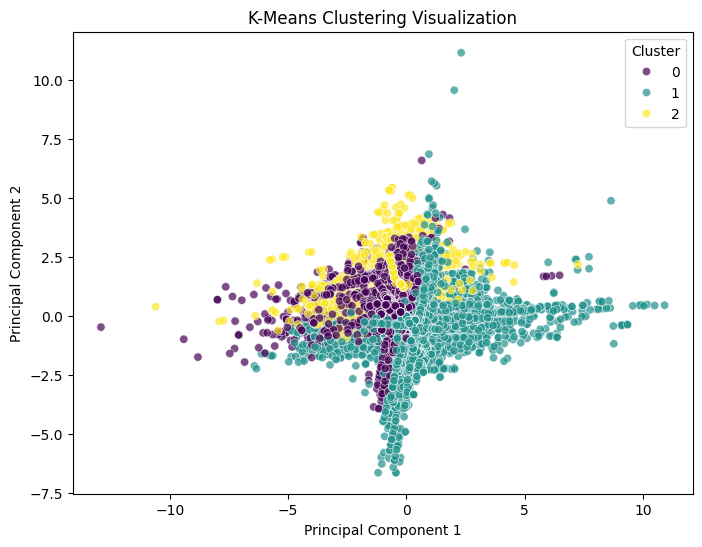

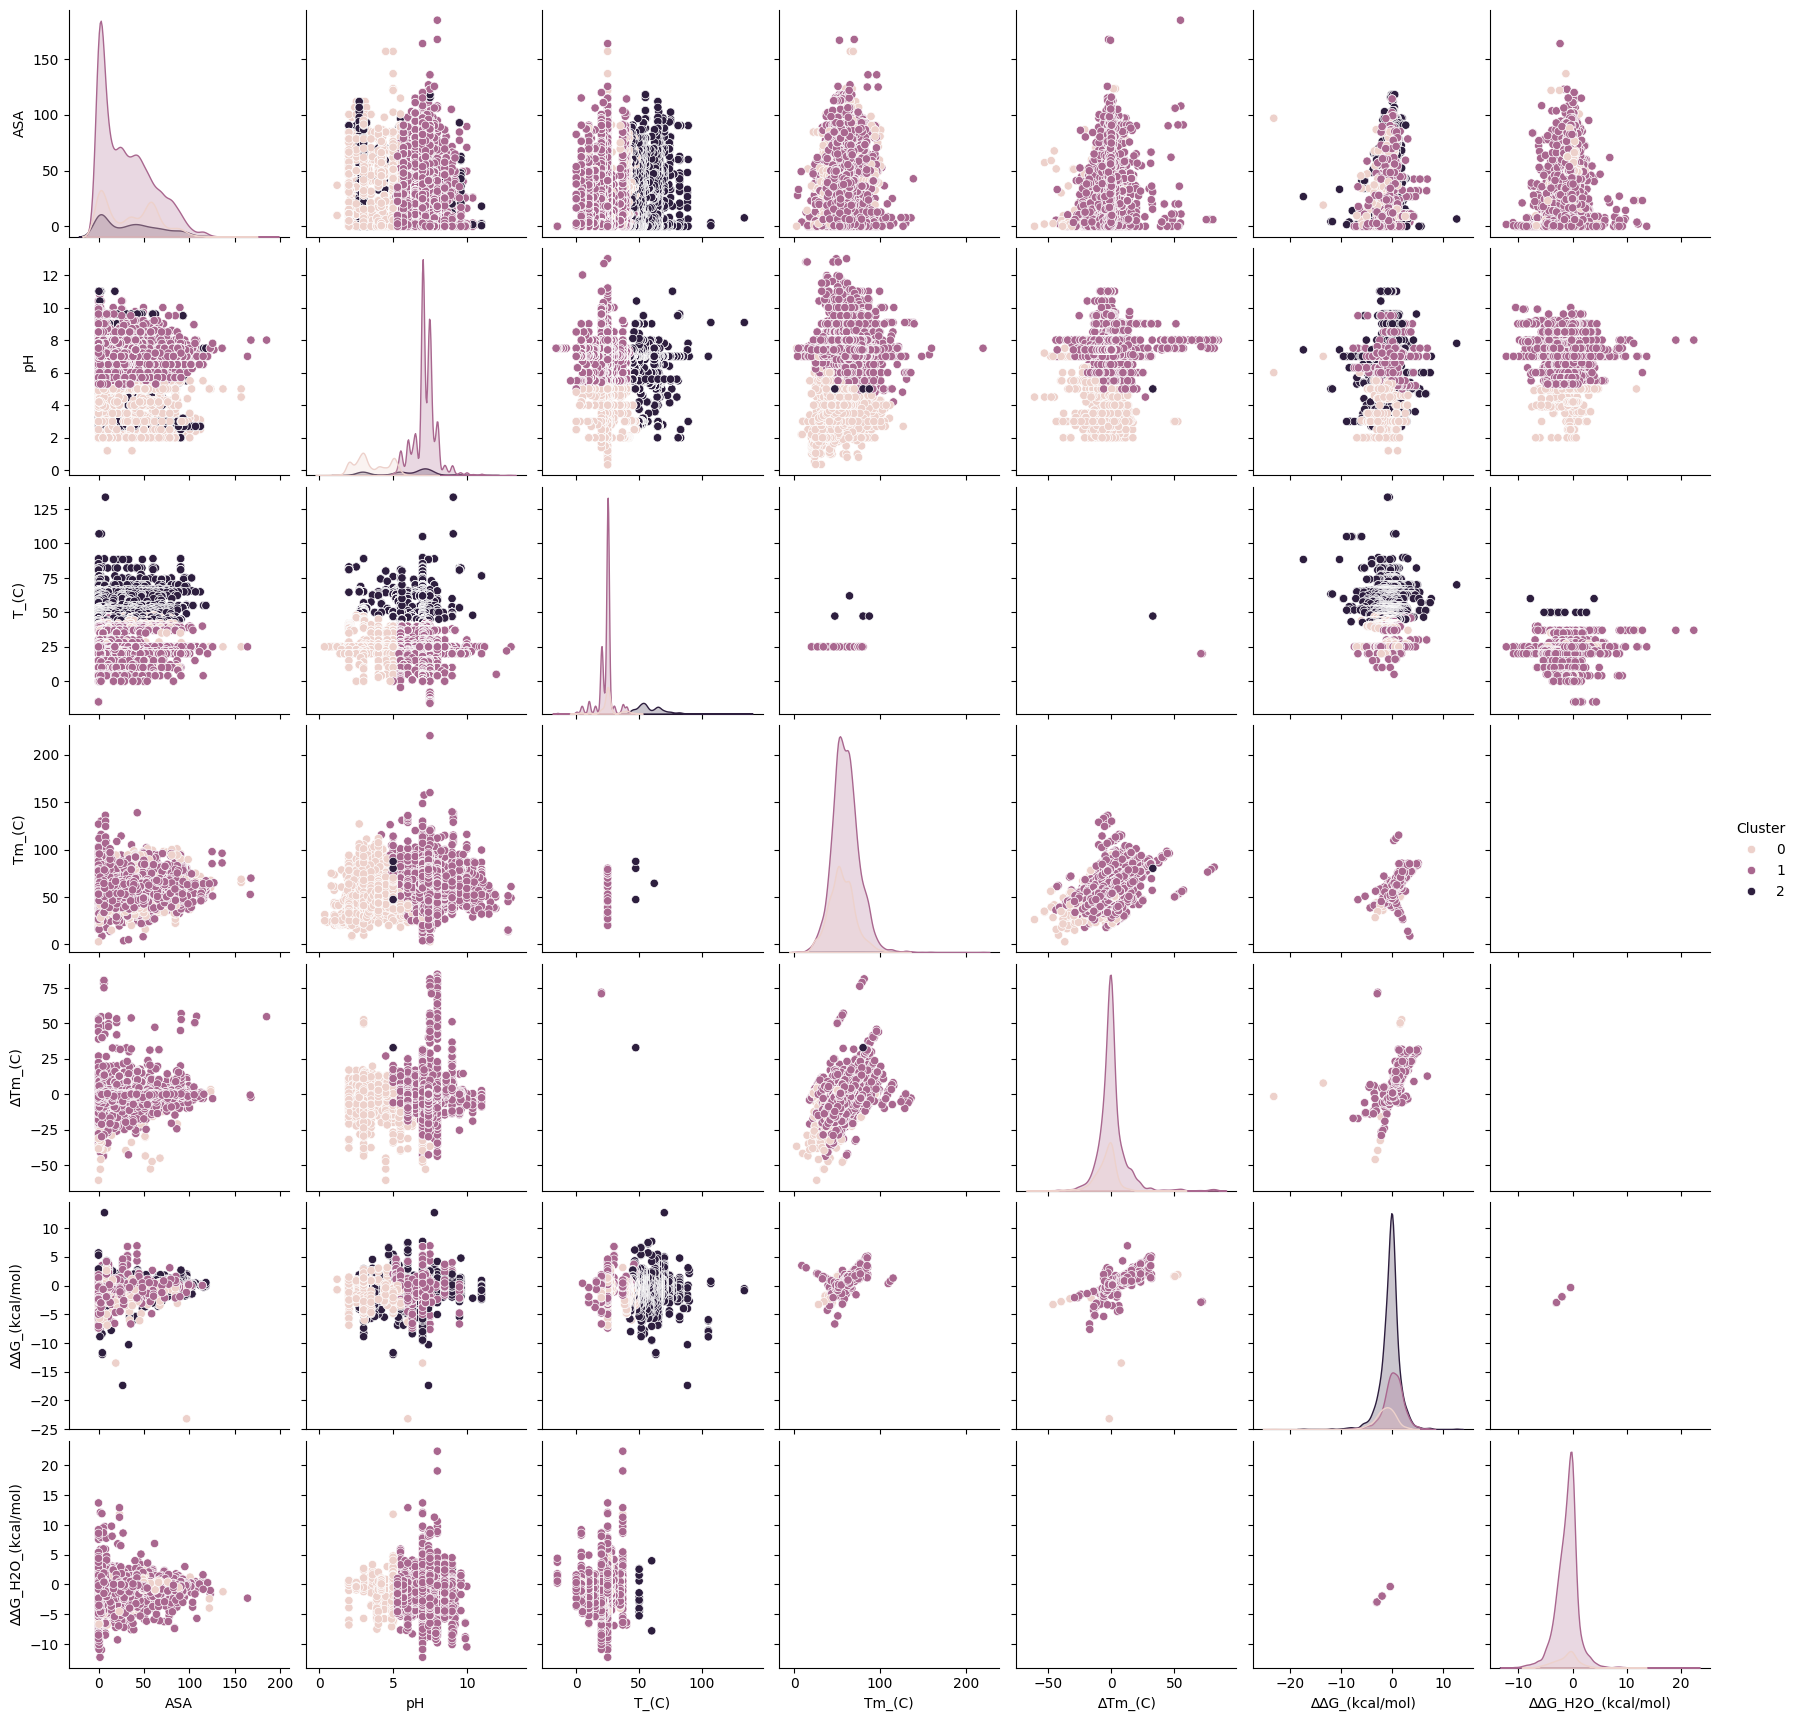

In [ ]:
# Performing K-Means Clustering and Finding optimal clusters using Elbow Method to see the clear separation.
# Visualizing the data through pairplot.

inertia = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_scaled)
df_cleaned["Cluster"] = kmeans_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=kmeans_labels, palette="viridis", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering Visualization")
plt.legend(title="Cluster")
plt.show()

sns.pairplot(df_cleaned, hue="Cluster", diag_kind="kde")
plt.show()

In [ ]:
# Removing the outlier to check once again for clusterization.

if mechano:
    df_filtered = df_cleaned[df_cleaned["Cluster"] != 0]
    df_filtered.info()
else:
    df_filtered = df_cleaned.copy()

In [ ]:
df_numeric_cleaned = df_filtered.select_dtypes(include=["int64", "float64"])
imputer = SimpleImputer(strategy="mean")
df_numeric_cleaned = pd.DataFrame(imputer.fit_transform(df_numeric_cleaned), columns=df_numeric_cleaned.columns)

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric_cleaned)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

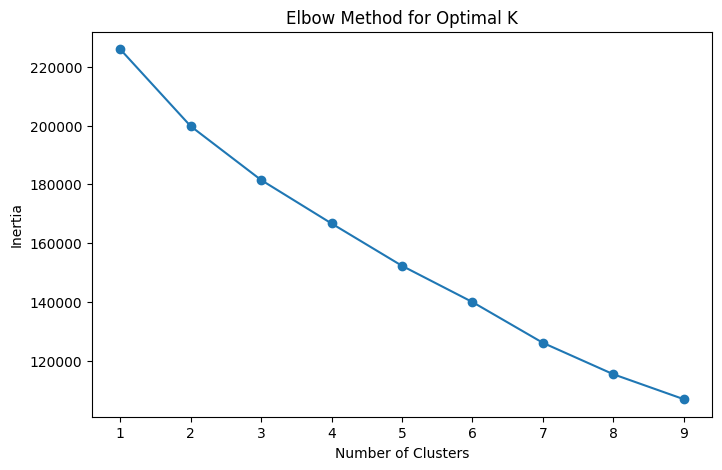

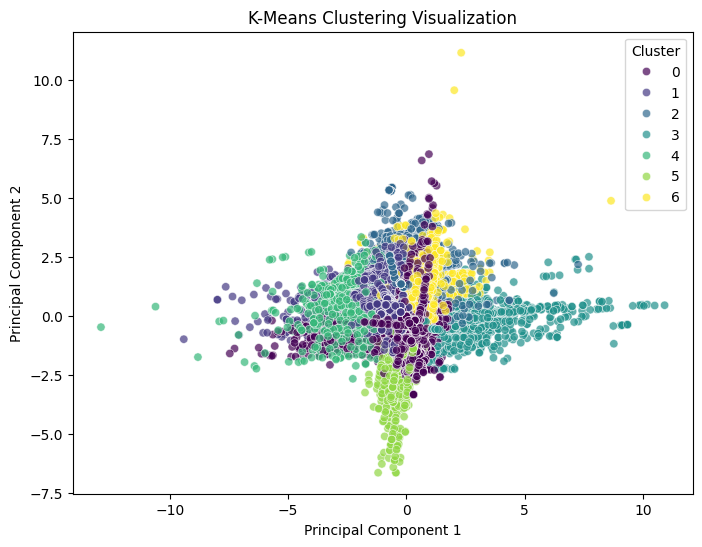

In [ ]:
# Once again performing K-Means clustering on updated_data without outlier.

inertia = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=kmeans_labels, palette="viridis", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering Visualization")
plt.legend(title="Cluster")
plt.show()


### DBSCAN

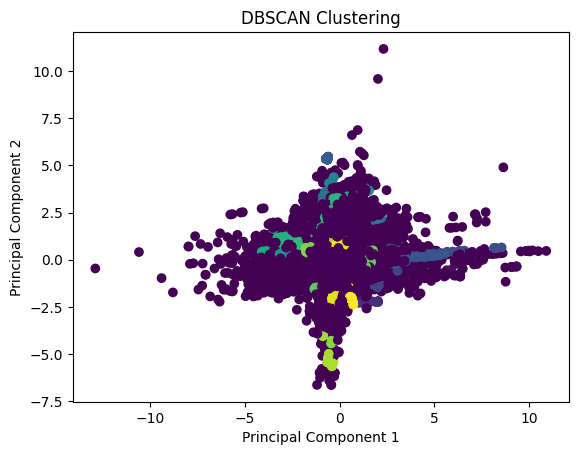

In [ ]:
# Trying to perform clustering using DBSCAN (results are even worse --> no clear separation).

X = df[numerical_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric_cleaned)

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap="viridis")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("DBSCAN Clustering")
plt.show()

# Feature Importance

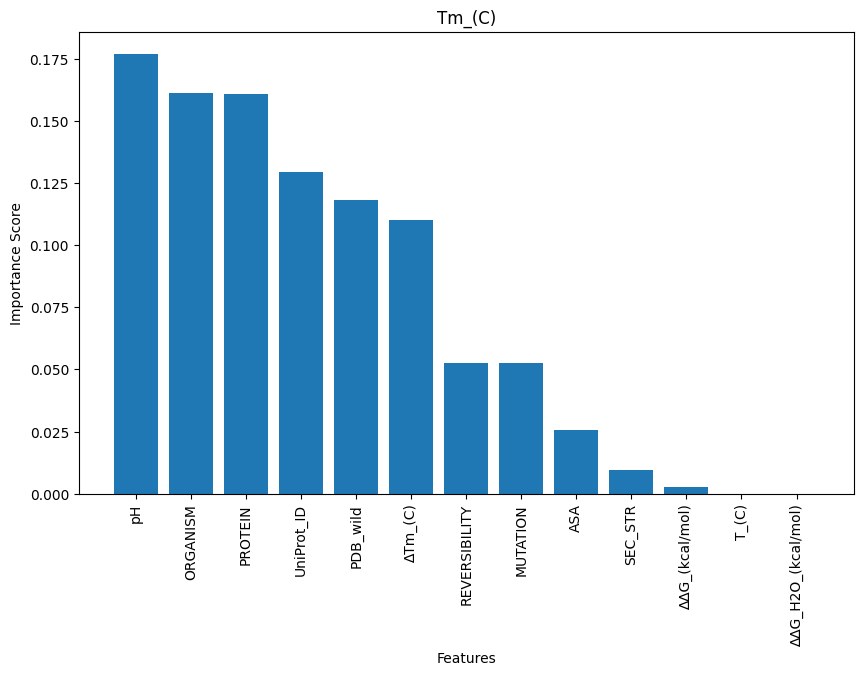

In [ ]:
# Training Random Forest Regressor to check for feature importance for each target variable.

df_encoded = df.copy()
label_encoders = {}
if mechano:
    targets = ["ΔG [kBT]", "Xu [nm]", "Koff [s-¹]"]
else:
    targets = ["Tm_(C)"]

for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le

for target_column in targets:
    temp_df = df_encoded.dropna(subset=[target_column])
    if temp_df.empty:
        print(f"Skipping {target_column} due to empty DataFrame after dropping NaNs.")
        continue

    X = temp_df.drop(columns=[target_column])
    y = temp_df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    feature_importance = rf_model.feature_importances_
    feature_names = X.columns
    sorted_indices = np.argsort(feature_importance)[::-1]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importance)), feature_importance[sorted_indices], align="center")
    plt.xticks(range(len(feature_importance)), np.array(feature_names)[sorted_indices], rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.title(target_column)
    plt.show()

# Correlations

In [ ]:
# Specifying the list of numeric columns to check for correlations

if mechano:
    numeric_cols = ["Standard Deviation of force [pN]", "Velocity [nm/s]",
                    "Xu [nm]","ΔG [kBT]","Contour Length [nm]", "Koff [s-¹]"]
else:
    numeric_cols = numerical_cols

In [ ]:
# Simple encoding of text features.

results = []
for cat_col in new_categorical_cols:
    encoded = LabelEncoder().fit_transform(df[cat_col].astype(str))

    for num_col in numeric_cols:
        x = encoded
        y = df[num_col].values

        mask = ~np.isnan(x) & ~np.isnan(y)
        x_clean = x[mask]
        y_clean = y[mask]

        if len(np.unique(x_clean)) <= 1 or len(np.unique(y_clean)) <= 1:
            pearson_corr, spearman_corr = np.nan, np.nan
        else:
            pearson_corr, _ = pearsonr(x_clean, y_clean)
            spearman_corr, _ = spearmanr(x_clean, y_clean)

        results.append({
            "Categorical": cat_col,
            "Numeric": num_col,
            "Pearson": pearson_corr,
            "Spearman": spearman_corr
        })

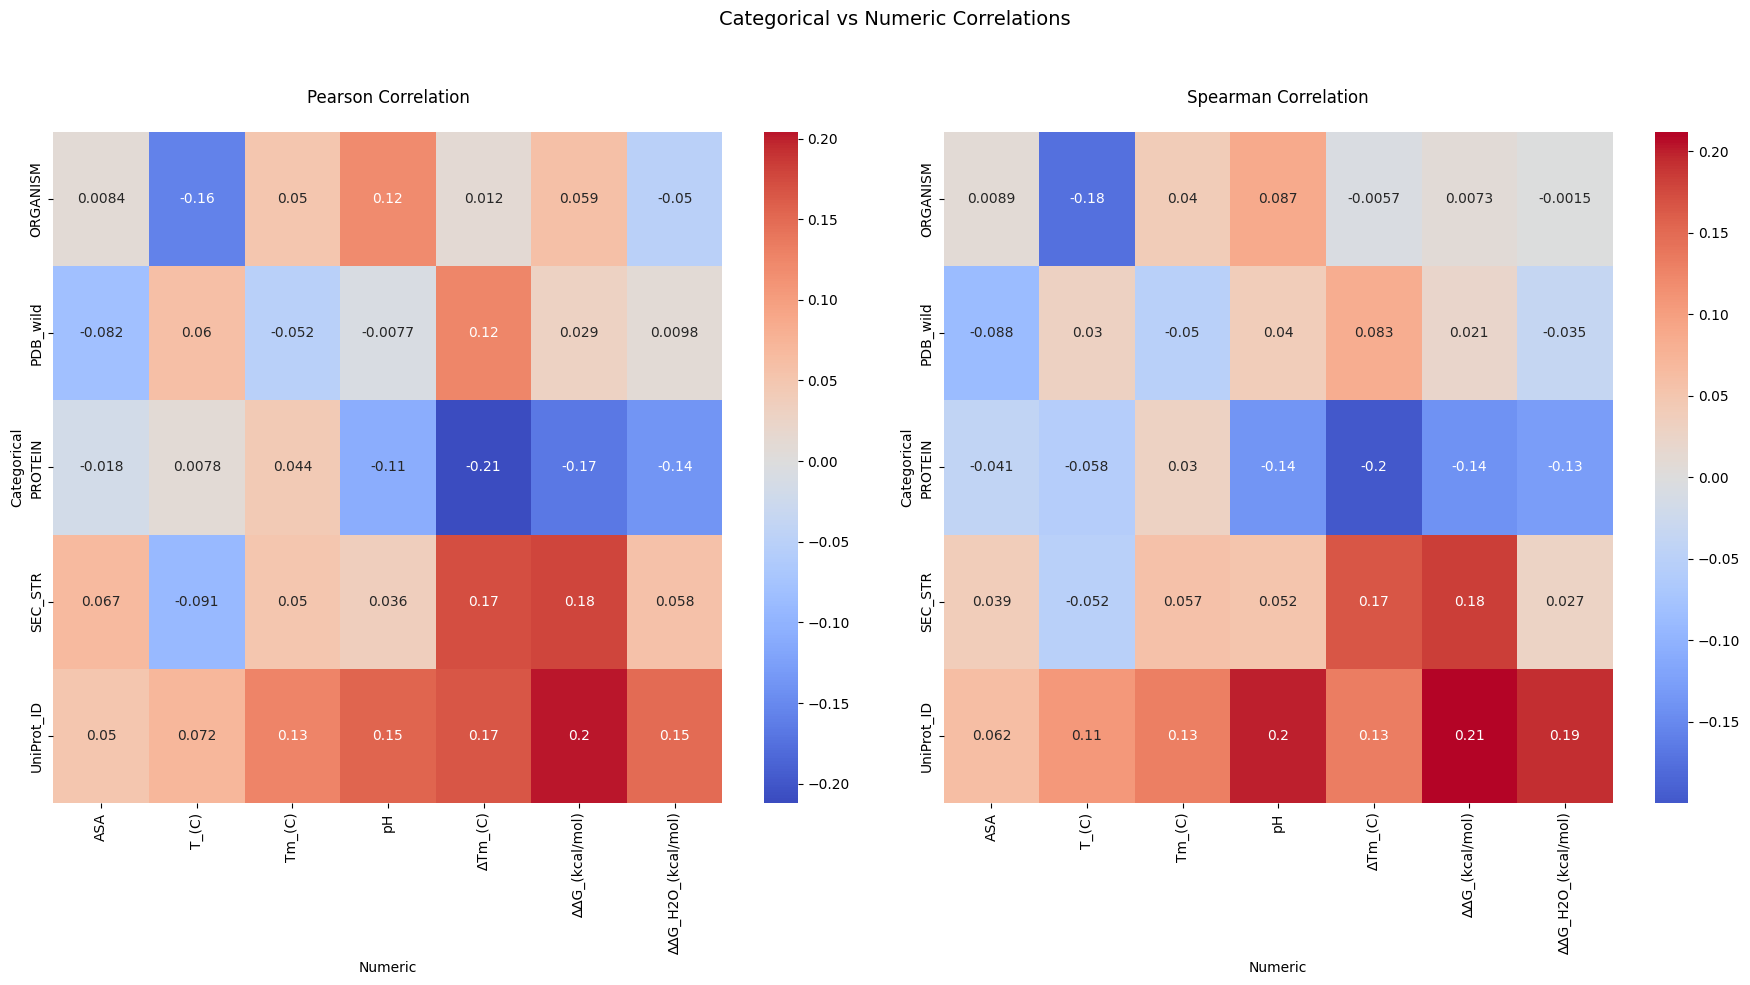

In [ ]:
# Creating heatmaps for categorical / numeric features to check for correlations.

correlation_df = pd.DataFrame(results)
pivot_pearson = correlation_df.pivot(index="Categorical", columns="Numeric", values="Pearson")
pivot_spearman = correlation_df.pivot(index="Categorical", columns="Numeric", values="Spearman")

plt.figure(figsize=(18, 10))
plt.suptitle("Categorical vs Numeric Correlations", fontsize=14)
plt.subplot(1, 2, 1)
sns.heatmap(pivot_pearson, annot=True, cmap="coolwarm", center=0)
plt.title("Pearson Correlation\n")
plt.subplot(1, 2, 2)
sns.heatmap(pivot_spearman, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman Correlation\n")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
all_cols = list(numeric_cols) + list(new_categorical_cols)

encoded_df = pd.DataFrame()
for col in all_cols:
    if col in pre_categorical_cols:
        encoded_df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    else:
        encoded_df[col] = df[col]

pearson_matrix = pd.DataFrame(np.nan, index=all_cols, columns=all_cols)
spearman_matrix = pd.DataFrame(np.nan, index=all_cols, columns=all_cols)

for col1 in all_cols:
    for col2 in all_cols:
        x = encoded_df[col1]
        y = encoded_df[col2]

        mask = ~pd.isna(x) & ~pd.isna(y)
        x_clean = x[mask]
        y_clean = y[mask]

        if len(np.unique(x_clean)) <= 1 or len(np.unique(y_clean)) <= 1:
            continue
        else:
            pearson_corr, _ = pearsonr(x_clean, y_clean)
            spearman_corr, _ = spearmanr(x_clean, y_clean)

        pearson_matrix.loc[col1, col2] = pearson_corr
        spearman_matrix.loc[col1, col2] = spearman_corr

In [ ]:
# Cleaning feature names from units for visualizations.

def clean_label(label, database=None):
    if database == "mechano":
        return re.sub(r'\s*[\[\(].*?[\]\)]\s*$', '', label)
    else:
        return label

cleaned_labels = [clean_label(col, database=database) for col in all_cols]


pearson_matrix.index = cleaned_labels
pearson_matrix.columns = cleaned_labels
spearman_matrix.index = cleaned_labels
spearman_matrix.columns = cleaned_labels

In [ ]:
# Visualizing correlations via Heatmaps.

plt.figure(figsize=(50, 14), dpi=400)

plt.subplot(1, 2, 1)
ax1 = sns.heatmap(
    pearson_matrix.astype(float),
    annot=True,
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    fmt=".2f",
    square=True,
    annot_kws={"size": 24},
    cbar=False
)

plt.title("Pearson Correlation\n", fontsize=25)
if mechano:
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
else:
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20, rotation=45)

plt.subplot(1, 2, 2)
ax2 = sns.heatmap(
    spearman_matrix.astype(float),
    annot=True,
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    fmt=".2f",
    square=True,
    annot_kws={"size": 24}
)

plt.title("Spearman Correlation\n", fontsize=25)
if mechano:
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
else:
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20, rotation=45)

ax2.collections[0].colorbar.ax.tick_params(labelsize=25)

if mechano:
    plt.tight_layout(rect=[0, 0, 1, 1.6])
else:
    plt.tight_layout(rect=[0, 0, 1, 1.2])

plt.show()

***

# END of Notebook